# Scope for this notebook
The objective of this notebook is dual:

- Final feature engineer on variables
- Create a first classification model to use as a baseline for subsequent models and optimizations
- Create a first regresion model to use as a baseline for subsequent models and optimizations


---

## Action plan:

**1. Split the dataset into two, one with 'news' features and a separate one with 'market' features**  
This is beneficial to group news by publication timestamp based on different criterias (see step 3)
 

**2. Transform categorical variables into numerical ones**  

**3. Group all the news published exactly at the same timestamp, as all of them combined could explain market reactions**  
- Try to predict the direction of the market grouping all the news published at the same time, all of them with the same weights regardless of the impact classification
- Same as before, but giving higher weights to news with higher impact (high=3, medium=2, low=1)
- Try to predict the direction of the market just with those news published in isolation 
- Try to predict the direction of the market for HIGH, MEDIUM, LOW news 


**4. Merge the datasets back again, joined by datetime**  






---

## Models to create:

- Just with data up to the publication of the new, is the pair going to be appreciated or devaluated?
- Using A + data with market reaction within the first 15 minutes, is the pair going to be appreciated or devaluated?



---

In [1]:
#!conda install -y -c anaconda graphviz

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor


import pydotplus
from IPython.display import Image
from sklearn import tree

In [3]:
pd.options.display.max_columns = None

In [4]:
df = pd.read_csv('../data/curated/features_rounded_news_USD_pair_EURUSD_2007_2018.csv')


### Step 1. Split the dataset into two

One with 'news' features and a separate one with 'market' features

In [5]:
df.columns.tolist()

['actual',
 'country',
 'datetime',
 'forecast',
 'forecast_error',
 'impact',
 'new',
 'previous',
 'previous_error',
 'week',
 'datetime_gmt',
 'forecast_error_ratio',
 'year',
 'quarter',
 'month',
 'weekday',
 'open_released',
 'high_released',
 'low_released',
 'close_released',
 'high_0_5_after',
 'low_0_5_after',
 'close_0_5_after',
 'volatility_0_5_after',
 'direction_candle_0_5_after',
 'direction_agg_0_5_after',
 'pips_agg_0_5_after',
 'pips_candle_0_5_after',
 'high_5_10_after',
 'low_5_10_after',
 'close_5_10_after',
 'volatility_5_10_after',
 'direction_candle_5_10_after',
 'direction_agg_5_10_after',
 'pips_agg_5_10_after',
 'pips_candle_5_10_after',
 'high_10_15_after',
 'low_10_15_after',
 'close_10_15_after',
 'volatility_10_15_after',
 'direction_candle_10_15_after',
 'direction_agg_10_15_after',
 'pips_agg_10_15_after',
 'pips_candle_10_15_after',
 'high_15_20_after',
 'low_15_20_after',
 'close_15_20_after',
 'volatility_15_20_after',
 'direction_candle_15_20_after'

In [6]:
df.head(1)

,actual,country,datetime,forecast,forecast_error,impact,new,previous,previous_error,week,datetime_gmt,forecast_error_ratio,year,quarter,month,weekday,open_released,high_released,low_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,direction_candle_0_5_after,direction_agg_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,direction_candle_5_10_after,direction_agg_5_10_after,pips_agg_5_10_after,pips_candle_5_10_after,high_10_15_after,low_10_15_after,close_10_15_after,volatility_10_15_after,direction_candle_10_15_after,direction_agg_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_15_20_after,low_15_20_after,close_15_20_after,volatility_15_20_after,direction_candle_15_20_after,direction_agg_15_20_after,pips_agg_15_20_after,pips_candle_15_20_after,high_20_25_after,low_20_25_after,close_20_25_after,volatility_20_25_after,direction_candle_20_25_after,direction_agg_20_25_after,pips_agg_20_25_after,pips_candle_20_25_after,high_5_0_before,low_5_0_before,close_5_0_before,volatility_5_0_before,direction_candle_5_0_before,pips_candle_5_0_before,high_10_5_before,low_10_5_before,close_10_5_before,volatility_10_5_before,direction_candle_10_5_before,pips_candle_10_5_before,high_15_10_before,low_15_10_before,close_15_10_before,volatility_15_10_before,direction_candle_15_10_before,pips_candle_15_10_before,high_20_15_before,low_20_15_before,close_20_15_before,volatility_20_15_before,direction_candle_20_15_before,pips_candle_20_15_before,high_25_20_before,low_25_20_before,close_25_20_before,volatility_25_20_before,direction_candle_25_20_before,pips_candle_25_20_before,high_15_30_after,low_15_30_after,close_15_30_after,volatility_15_30_after,direction_candle_15_30_after,direction_agg_15_30_after,pips_agg_15_30_after,pips_candle_15_30_after,high_30_45_after,low_30_45_after,close_30_45_after,volatility_30_45_after,direction_candle_30_45_after,direction_agg_30_45_after,pips_agg_30_45_after,pips_candle_30_45_after,high_45_60_after,low_45_60_after,close_45_60_after,volatility_45_60_after,direction_candle_45_60_after,direction_agg_45_60_after,pips_agg_45_60_after,pips_candle_45_60_after,high_30_15_before,low_30_15_before,close_30_15_before,volatility_30_15_before,direction_candle_30_15_before,pips_candle_30_15_before,high_45_30_before,low_45_30_before,close_45_30_before,volatility_45_30_before,direction_candle_45_30_before,pips_candle_45_30_before,high_60_45_before,low_60_45_before,close_60_45_before,volatility_60_45_before,direction_candle_60_45_before,pips_candle_60_45_before,high_60_90_after,low_60_90_after,close_60_90_after,volatility_60_90_after,direction_candle_60_90_after,direction_agg_60_90_after,pips_agg_60_90_after,pips_candle_60_90_after,high_90_120_after,low_90_120_after,close_90_120_after,volatility_90_120_after,direction_candle_90_120_after,direction_agg_90_120_after,pips_agg_90_120_after,pips_candle_90_120_after,high_120_150_after,low_120_150_after,close_120_150_after,volatility_120_150_after,direction_candle_120_150_after,direction_agg_120_150_after,pips_agg_120_150_after,pips_candle_120_150_after,high_150_180_after,low_150_180_after,close_150_180_after,volatility_150_180_after,direction_candle_150_180_after,direction_agg_150_180_after,pips_agg_150_180_after,pips_candle_150_180_after,high_180_210_after,low_180_210_after,close_180_210_after,volatility_180_210_after,direction_candle_180_210_after,direction_agg_180_210_after,pips_agg_180_210_after,pips_candle_180_210_after,high_210_240_after,low_210_240_after,close_210_240_after,volatility_210_240_after,direction_candle_210_240_after,direction_agg_210_240_after,pips_agg_210_240_after,pips_candle_210_240_after,high_90_60_before,low_90_60_before,close_90_60_before,volatility_90_60_before,direction_candle_90_60_before,pips_candle_90_60_before,high_120_90_before,low_120_90_before,close_120_90_before,volatility_120_90_before,direction_candle_120_90_before,pips_candle_120_90

In [7]:
columns_of_interest_news = ['datetime',
                             'forecast_error',
                             'impact',
                             'new',
                             'previous_error',
                             'datetime_gmt',
                             'forecast_error_ratio',
                             'previous_error_ratio',
                             'total_error_ratio',
                             'forecast_error_ratio_zscore',
                             'total_error_ratio_zscore']

In [8]:
columns_to_predict = ['close_45_60_after',
                      'pips_agg_45_60_after',
                                 'direction_agg_45_60_after',
                                 'close_60_90_after',
                                 'pips_agg_60_90_after',
                                 'direction_agg_60_90_after',
                                 'close_90_120_after',
                                 'pips_agg_90_120_after',
                                 'direction_agg_90_120_after',
                                 'close_120_150_after',
                                 'pips_agg_120_150_after',
                                 'direction_agg_120_150_after',
                                 'close_150_180_after',
                                 'pips_agg_150_180_after',
                                 'direction_agg_150_180_after',
                                 'close_180_210_after',
                                 'pips_agg_180_210_after',
                                 'direction_agg_180_210_after',
                                 'close_210_240_after',
                                 'pips_agg_210_240_after',
                                 'direction_agg_210_240_after']



In [9]:
columns_of_interest_market = ['datetime',
                                 'year',
                                 'quarter',
                                 'month',
                                 'weekday',
                                 'week',
                                 'open_released',
                                 'close_released',
                                 'high_0_5_after',
                                 'low_0_5_after',
                                 'close_0_5_after',
                                 'volatility_0_5_after',
                                 'pips_agg_0_5_after',
                                 'pips_candle_0_5_after',
                                 'high_5_10_after',
                                 'low_5_10_after',
                                 'close_5_10_after',
                                 'volatility_5_10_after',
                                 'pips_agg_5_10_after',
                                 'pips_candle_5_10_after',
                                 'high_10_15_after',
                                 'low_10_15_after',
                                 'close_10_15_after',
                                 'volatility_10_15_after',
                                 'pips_agg_10_15_after',
                                 'pips_candle_10_15_after',
                                 'high_5_0_before',
                                 'low_5_0_before',
                                 'close_5_0_before',
                                 'volatility_5_0_before',
                                 'pips_candle_5_0_before',
                                 'high_10_5_before',
                                 'low_10_5_before',
                                 'close_10_5_before',
                                 'volatility_10_5_before',
                                 'pips_candle_10_5_before',
                                 'high_15_10_before',
                                 'low_15_10_before',
                                 'close_15_10_before',
                                 'volatility_15_10_before',
                                 'pips_candle_15_10_before',
                                 'high_30_15_before',
                                 'low_30_15_before',
                                 'close_30_15_before',
                                 'volatility_30_15_before',
                                 'pips_candle_30_15_before',
                                 'high_45_30_before',
                                 'low_45_30_before',
                                 'close_45_30_before',
                                 'volatility_45_30_before',
                                 'pips_candle_45_30_before',
                                 'high_60_45_before',
                                 'low_60_45_before',
                                 'close_60_45_before',
                                 'volatility_60_45_before',
                                 'pips_candle_60_45_before',
                                 'high_90_60_before',
                                 'low_90_60_before',
                                 'close_90_60_before',
                                 'volatility_90_60_before',
                                 'pips_candle_90_60_before',
                                 'high_120_90_before',
                                 'low_120_90_before',
                                 'close_120_90_before',
                                 'volatility_120_90_before',
                                 'pips_candle_120_90_before',
                                 'high_150_120_before',
                                 'low_150_120_before',
                                 'close_150_120_before',
                                 'volatility_150_120_before',
                                 'pips_candle_150_120_before',
                                 'high_180_150_before',
                                 'low_180_150_before',
                                 'close_180_150_before',
                                 'volatility_180_150_before',
                                 'pips_candle_180_150_before',
                                 'high_210_180_before',
                                 'low_210_180_before',
                                 'close_210_180_before',
                                 'volatility_210_180_before',
                                 'pips_candle_210_180_before',
                                 'high_240_210_before',
                                 'low_240_210_before',
                                 'close_240_210_before',
                                 'volatility_240_210_before',
                                 'pips_candle_240_210_before']

In [10]:
len(df)

9667

In [11]:
df_news = df[columns_of_interest_news].copy()
df_market = df[columns_of_interest_market + columns_to_predict].copy()

In [12]:
df_news.head(2)

,datetime,forecast_error,impact,new,previous_error,datetime_gmt,forecast_error_ratio,previous_error_ratio,total_error_ratio,forecast_error_ratio_zscore,total_error_ratio_zscore
0,2007-01-08 15:00:00,better,Low,Consumer Credit m/m,accurate,2007-01-08 20:00:00+00:00,127.78,0.00,127.78,0.000000,0.000000
1,2007-02-07 15:00:00,worse,Low,Consumer Credit m/m,better,2007-02-07 20:00:00+00:00,-14.29,11.38,-2.91,-0.707107,-0.707107


In [13]:
df_market.head(2)

,datetime,year,quarter,month,weekday,week,open_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,pips_agg_5_10_after,pips_candle_5_10_after,high_10_15_after,low_10_15_after,close_10_15_after,volatility_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_5_0_before,low_5_0_before,close_5_0_before,volatility_5_0_before,pips_candle_5_0_before,high_10_5_before,low_10_5_before,close_10_5_before,volatility_10_5_before,pips_candle_10_5_before,high_15_10_before,low_15_10_before,close_15_10_before,volatility_15_10_before,pips_candle_15_10_before,high_30_15_before,low_30_15_before,close_30_15_before,volatility_30_15_before,pips_candle_30_15_before,high_45_30_before,low_45_30_before,close_45_30_before,volatility_45_30_before,pips_candle_45_30_before,high_60_45_before,low_60_45_before,close_60_45_before,volatility_60_45_before,pips_candle_60_45_before,high_90_60_before,low_90_60_before,close_90_60_before,volatility_90_60_before,pips_candle_90_60_before,high_120_90_before,low_120_90_before,close_120_90_before,volatility_120_90_before,pips_candle_120_90_before,high_150_120_before,low_150_120_before,close_150_120_before,volatility_150_120_before,pips_candle_150_120_before,high_180_150_before,low_180_150_before,close_180_150_before,volatility_180_150_before,pips_candle_180_150_before,high_210_180_before,low_210_180_before,close_210_180_before,volatility_210_180_before,pips_candle_210_180_before,high_240_210_before,low_240_210_before,close_240_210_before,volatility_240_210_before,pips_candle_240_210_before,close_45_60_after,pips_agg_45_60_after,direction_agg_45_60_after,close_60_90_after,pips_agg_60_90_after,direction_agg_60_90_after,close_90_120_after,pips_agg_90_120_after,direction_agg_90_120_after,close_120_150_after,pips_agg_120_150_after,direction_agg_120_150_after,close_150_180_after,pips_agg_150_180_after,direction_agg_150_180_after,close_180_210_after,pips_agg_180_210_after,direction_agg_180_210_after,close_210_240_after,pips_agg_210_240_after,direction_agg_210_240_after
0,2007-01-08 15:00:00,2007,1,1,0,2,13018,13018,13022,13016,13019,6,1,0,13020,13016,13017,4,-1,-2,13022,13013,13019,9,1,1,13020,13016,13018,4,0,13022,13016,13018,6,0,13020,13015,13018,5,-1,13022,13015,13018,7,2,13021,13014,13016,7,-1,13020,13008,13017,12,2,13035,13014,13015,21,-3,13031,13018,13018,13,-11,13034,13014,13029,20,8,13031,13019,13021,12,-9,13034,13009,13032,25,23,13014,13001,13009,13,1,13019,1,up,13016,-2,down,13022,4,up,13025,7,up,13023,5,up,13027,9,up,13036,18,up
1,2007-02-07 15:00:00,2007,1,2,2,6,13007,13005,13006,13003,13006,3,1,1,13010,13004,13005,6,0,0,13008,13003,13005,5,0,-2,13008,13002,13005,6,-2,13009,13005,13007,4,-1,13009,13005,13008,4,1,13010,13003,13008,7,2,13011,13006,13009,5,-1,13017,13004,13010,13,-6,13018,13006,13016,12,8,13017,13008,13009,9,-1,13019,13008,13009,11,-3,13019,13009,13013,10,-5,13021,13010,13019,11,1,13023,13011,13018,12,0,13011,6,up,13011,6,up,13012,7,up,13013,8,up,13012,7,up,13014,9,up,13019,14,up


### Step 2. Transform categorical features into numerical ones as follows

1. Some variables will be encoded using One Hot encoder:
    - forecast_error
    - previous_error 
    - impact
2. fit transform for the name of the news

In [14]:
df_news.select_dtypes(include='object').head(2)

,datetime,forecast_error,impact,new,previous_error,datetime_gmt
0,2007-01-08 15:00:00,better,Low,Consumer Credit m/m,accurate,2007-01-08 20:00:00+00:00
1,2007-02-07 15:00:00,worse,Low,Consumer Credit m/m,better,2007-02-07 20:00:00+00:00


In [15]:
le = preprocessing.LabelEncoder()

df_news['new_id'] = le.fit_transform(df_news['new'])

dummy_forecast_error = pd.get_dummies(df_news['forecast_error'])
dummy_forecast_error.columns = ['fe_accurate', 'fe_better', 'fe_worse']
dummy_previous_error = pd.get_dummies(df_news['previous_error'])
dummy_previous_error.columns = ['pe_accurate', 'pe_better', 'pe_worse']
dummy_impact = pd.get_dummies(df_news['impact'])

In [16]:
dummy_previous_error.head(2)

,pe_accurate,pe_better,pe_worse
0,1,0,0
1,0,1,0


In [17]:
dummy_impact.head(2)

,High,Low,Medium
0,0,1,0
1,0,1,0


In [18]:
len(df_news)

9667

In [19]:
df_news = pd.concat([df_news, dummy_forecast_error, dummy_previous_error, dummy_impact], axis=1)
df_news.head(2)

,datetime,forecast_error,impact,new,previous_error,datetime_gmt,forecast_error_ratio,previous_error_ratio,total_error_ratio,forecast_error_ratio_zscore,total_error_ratio_zscore,new_id,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium
0,2007-01-08 15:00:00,better,Low,Consumer Credit m/m,accurate,2007-01-08 20:00:00+00:00,127.78,0.00,127.78,0.000000,0.000000,12,0,1,0,1,0,0,0,1,0
1,2007-02-07 15:00:00,worse,Low,Consumer Credit m/m,better,2007-02-07 20:00:00+00:00,-14.29,11.38,-2.91,-0.707107,-0.707107,12,0,0,1,0,1,0,0,1,0


In [20]:
len(df_news)

9667

In [21]:
df_news = df_news.drop(['new', 'datetime_gmt', 'forecast_error', 'impact', 'previous_error'], axis=1)

In [22]:
df_news['new_id'] = df_news['new_id'].astype(str)

In [23]:
df_news.head(2)

,datetime,forecast_error_ratio,previous_error_ratio,total_error_ratio,forecast_error_ratio_zscore,total_error_ratio_zscore,new_id,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium
0,2007-01-08 15:00:00,127.78,0.00,127.78,0.000000,0.000000,12,0,1,0,1,0,0,0,1,0
1,2007-02-07 15:00:00,-14.29,11.38,-2.91,-0.707107,-0.707107,12,0,0,1,0,1,0,0,1,0


In [24]:
len(list(df_news.columns))

16

In [25]:
len(df_news)

9667

### Step 3: Group news by datetime of publication

In [26]:
df_by_datetime_baseline = df_news.groupby('datetime').agg({'new_id': lambda x:list(x), 
                                                 'forecast_error_ratio': lambda x:list(x),
                                                 'forecast_error_ratio_zscore': lambda x:list(x),
                                                 'previous_error_ratio': lambda x:list(x),
                                                 'forecast_error_ratio_zscore': lambda x:list(x),
                                                 'total_error_ratio': lambda x:list(x),
                                                 'total_error_ratio_zscore': lambda x:list(x),
                                                 'fe_accurate': lambda x:list(x),
                                                 'fe_better': lambda x:list(x),
                                                 'fe_worse': lambda x:list(x),
                                                 'pe_accurate': lambda x:list(x),
                                                 'pe_better': lambda x:list(x),
                                                 'pe_worse': lambda x:list(x),
                                                 'High': lambda x:list(x),
                                                 'Low': lambda x:list(x),
                                                 'Medium': lambda x:list(x)
                                                }).reset_index()


In [27]:
df_by_datetime_baseline['num_news'] = df_by_datetime_baseline['new_id'].apply(lambda x: len(x))
df_by_datetime_baseline['new_id'] = df_by_datetime_baseline['new_id'].apply(lambda x: ['_'.join(x)])
df_by_datetime_baseline.head(2)

,datetime,new_id,forecast_error_ratio,forecast_error_ratio_zscore,previous_error_ratio,total_error_ratio,total_error_ratio_zscore,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium,num_news
0,2007-01-08 15:00:00,[12],[127.78],[0.0],[0.0],[127.78],[0.0],[0],[1],[0],[1],[0],[0],[0],[1],[0],1
1,2007-01-09 10:00:00,[37],[0.0],[0.0],[0.0],[0.0],[0.0],[1],[0],[0],[1],[0],[0],[0],[1],[0],1


In [28]:
df_by_datetime_baseline[df_by_datetime_baseline['num_news'] != 1].head(2)

,datetime,new_id,forecast_error_ratio,forecast_error_ratio_zscore,previous_error_ratio,total_error_ratio,total_error_ratio_zscore,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium,num_news
7,2007-01-12 08:30:00,[17_60_41],"[100.0, 50.0, 120.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[100.0, 50.0, 120.0]","[0.0, 0.0, 0.0]","[0, 0, 0]","[1, 1, 1]","[0, 0, 0]","[1, 1, 1]","[0, 0, 0]","[0, 0, 0]","[1, 1, 0]","[0, 0, 0]","[0, 0, 1]",3
11,2007-01-17 08:30:00,[49_16],"[50.0, 100.0]","[0.0, 0.0]","[0.0, 0.0]","[50.0, 100.0]","[0.0, 0.0]","[0, 0]","[1, 1]","[0, 0]","[1, 1]","[0, 0]","[0, 0]","[1, 0]","[0, 0]","[0, 1]",2


Which % of news are published on their own?

In [29]:
len(df_by_datetime_baseline[df_by_datetime_baseline['num_news'] == 1]) *100 /len(df_by_datetime_baseline)

70.92879256965944

### Model1: weight=1 to all news, regardless the "impact" classification

- weight = 1 to all news, regardless the 'impact' classification
- including open-high-low-close as well as volatility / pip / etc for each timestamp. Some information is redundant

In [30]:
df_model_1 = df_by_datetime_baseline.copy()

In [31]:
df_model_1['new_id'] = df_model_1['new_id'].apply(lambda x: x[0])

In [32]:
df_model_1.head(2)

,datetime,new_id,forecast_error_ratio,forecast_error_ratio_zscore,previous_error_ratio,total_error_ratio,total_error_ratio_zscore,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium,num_news
0,2007-01-08 15:00:00,12,[127.78],[0.0],[0.0],[127.78],[0.0],[0],[1],[0],[1],[0],[0],[0],[1],[0],1
1,2007-01-09 10:00:00,37,[0.0],[0.0],[0.0],[0.0],[0.0],[1],[0],[0],[1],[0],[0],[0],[1],[0],1


In [33]:
columns = df_model_1.columns[2:-1]

In [34]:
columns

Index(['forecast_error_ratio', 'forecast_error_ratio_zscore',
       'previous_error_ratio', 'total_error_ratio', 'total_error_ratio_zscore',
       'fe_accurate', 'fe_better', 'fe_worse', 'pe_accurate', 'pe_better',
       'pe_worse', 'High', 'Low', 'Medium'],
      dtype='object')

In [35]:
for field in columns:
    df_model_1[field] = df_model_1[field].apply(lambda x: sum(x))



In [36]:
df_model_1[df_model_1['num_news'] != 1].head(2)

,datetime,new_id,forecast_error_ratio,forecast_error_ratio_zscore,previous_error_ratio,total_error_ratio,total_error_ratio_zscore,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium,num_news
7,2007-01-12 08:30:00,17_60_41,270.0,0.0,0.0,270.0,0.0,0,3,0,3,0,0,2,0,1,3
11,2007-01-17 08:30:00,49_16,150.0,0.0,0.0,150.0,0.0,0,2,0,2,0,0,1,0,1,2


In [37]:
df_by_datetime_baseline[df_by_datetime_baseline['num_news'] != 1].head(2)

,datetime,new_id,forecast_error_ratio,forecast_error_ratio_zscore,previous_error_ratio,total_error_ratio,total_error_ratio_zscore,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium,num_news
7,2007-01-12 08:30:00,[17_60_41],"[100.0, 50.0, 120.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[100.0, 50.0, 120.0]","[0.0, 0.0, 0.0]","[0, 0, 0]","[1, 1, 1]","[0, 0, 0]","[1, 1, 1]","[0, 0, 0]","[0, 0, 0]","[1, 1, 0]","[0, 0, 0]","[0, 0, 1]",3
11,2007-01-17 08:30:00,[49_16],"[50.0, 100.0]","[0.0, 0.0]","[0.0, 0.0]","[50.0, 100.0]","[0.0, 0.0]","[0, 0]","[1, 1]","[0, 0]","[1, 1]","[0, 0]","[0, 0]","[1, 0]","[0, 0]","[0, 1]",2


In [38]:
len(df_model_1)

6460

## Join this new dataframe with the pair information

In [39]:
len(df_market)

9667

In [40]:
df_market = df_market.drop_duplicates()

In [41]:
df_model_1 = df_model_1.merge(df_market, on='datetime', how='left')
df_model_1.head(2)

,datetime,new_id,forecast_error_ratio,forecast_error_ratio_zscore,previous_error_ratio,total_error_ratio,total_error_ratio_zscore,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium,num_news,year,quarter,month,weekday,week,open_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,pips_agg_5_10_after,pips_candle_5_10_after,high_10_15_after,low_10_15_after,close_10_15_after,volatility_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_5_0_before,low_5_0_before,close_5_0_before,volatility_5_0_before,pips_candle_5_0_before,high_10_5_before,low_10_5_before,close_10_5_before,volatility_10_5_before,pips_candle_10_5_before,high_15_10_before,low_15_10_before,close_15_10_before,volatility_15_10_before,pips_candle_15_10_before,high_30_15_before,low_30_15_before,close_30_15_before,volatility_30_15_before,pips_candle_30_15_before,high_45_30_before,low_45_30_before,close_45_30_before,volatility_45_30_before,pips_candle_45_30_before,high_60_45_before,low_60_45_before,close_60_45_before,volatility_60_45_before,pips_candle_60_45_before,high_90_60_before,low_90_60_before,close_90_60_before,volatility_90_60_before,pips_candle_90_60_before,high_120_90_before,low_120_90_before,close_120_90_before,volatility_120_90_before,pips_candle_120_90_before,high_150_120_before,low_150_120_before,close_150_120_before,volatility_150_120_before,pips_candle_150_120_before,high_180_150_before,low_180_150_before,close_180_150_before,volatility_180_150_before,pips_candle_180_150_before,high_210_180_before,low_210_180_before,close_210_180_before,volatility_210_180_before,pips_candle_210_180_before,high_240_210_before,low_240_210_before,close_240_210_before,volatility_240_210_before,pips_candle_240_210_before,close_45_60_after,pips_agg_45_60_after,direction_agg_45_60_after,close_60_90_after,pips_agg_60_90_after,direction_agg_60_90_after,close_90_120_after,pips_agg_90_120_after,direction_agg_90_120_after,close_120_150_after,pips_agg_120_150_after,direction_agg_120_150_after,close_150_180_after,pips_agg_150_180_after,direction_agg_150_180_after,close_180_210_after,pips_agg_180_210_after,direction_agg_180_210_after,close_210_240_after,pips_agg_210_240_after,direction_agg_210_240_after
0,2007-01-08 15:00:00,12,127.78,0.0,0.0,127.78,0.0,0,1,0,1,0,0,0,1,0,1,2007,1,1,0,2,13018,13018,13022,13016,13019,6,1,0,13020,13016,13017,4,-1,-2,13022,13013,13019,9,1,1,13020,13016,13018,4,0,13022,13016,13018,6,0,13020,13015,13018,5,-1,13022,13015,13018,7,2,13021,13014,13016,7,-1,13020,13008,13017,12,2,13035,13014,13015,21,-3,13031,13018,13018,13,-11,13034,13014,13029,20,8,13031,13019,13021,12,-9,13034,13009,13032,25,23,13014,13001,13009,13,1,13019,1,up,13016,-2,down,13022,4,up,13025,7,up,13023,5,up,13027,9,up,13036,18,up
1,2007-01-09 10:00:00,37,0.00,0.0,0.0,0.00,0.0,1,0,0,1,0,0,0,1,0,1,2007,1,1,1,2,12999,13000,13003,12998,13000,5,0,0,13007,13000,13002,7,2,1,13003,12998,13001,5,1,-2,13004,12995,13000,9,1,13001,12995,12998,6,1,13009,12996,12997,13,-10,13015,12996,12997,19,-11,13010,13000,13009,10,3,13012,13001,13009,11,6,13025,13006,13007,19,-15,13028,13013,13022,15,8,13019,13006,13016,13,3,13023,13009,13013,14,-6,13026,13017,13019,9,-2,13037,13024,13024,13,-8,12998,-2,down,12997,-3,down,12994,-6,down,13001,1,up,13007,7,up,13012,12,up,13007,7,up


In [42]:
len(df_model_1)

6460

In [43]:
df_model_1[df_model_1['num_news'] != 1].head(2)

,datetime,new_id,forecast_error_ratio,forecast_error_ratio_zscore,previous_error_ratio,total_error_ratio,total_error_ratio_zscore,fe_accurate,fe_better,fe_worse,pe_accurate,pe_better,pe_worse,High,Low,Medium,num_news,year,quarter,month,weekday,week,open_released,close_released,high_0_5_after,low_0_5_after,close_0_5_after,volatility_0_5_after,pips_agg_0_5_after,pips_candle_0_5_after,high_5_10_after,low_5_10_after,close_5_10_after,volatility_5_10_after,pips_agg_5_10_after,pips_candle_5_10_after,high_10_15_after,low_10_15_after,close_10_15_after,volatility_10_15_after,pips_agg_10_15_after,pips_candle_10_15_after,high_5_0_before,low_5_0_before,close_5_0_before,volatility_5_0_before,pips_candle_5_0_before,high_10_5_before,low_10_5_before,close_10_5_before,volatility_10_5_before,pips_candle_10_5_before,high_15_10_before,low_15_10_before,close_15_10_before,volatility_15_10_before,pips_candle_15_10_before,high_30_15_before,low_30_15_before,close_30_15_before,volatility_30_15_before,pips_candle_30_15_before,high_45_30_before,low_45_30_before,close_45_30_before,volatility_45_30_before,pips_candle_45_30_before,high_60_45_before,low_60_45_before,close_60_45_before,volatility_60_45_before,pips_candle_60_45_before,high_90_60_before,low_90_60_before,close_90_60_before,volatility_90_60_before,pips_candle_90_60_before,high_120_90_before,low_120_90_before,close_120_90_before,volatility_120_90_before,pips_candle_120_90_before,high_150_120_before,low_150_120_before,close_150_120_before,volatility_150_120_before,pips_candle_150_120_before,high_180_150_before,low_180_150_before,close_180_150_before,volatility_180_150_before,pips_candle_180_150_before,high_210_180_before,low_210_180_before,close_210_180_before,volatility_210_180_before,pips_candle_210_180_before,high_240_210_before,low_240_210_before,close_240_210_before,volatility_240_210_before,pips_candle_240_210_before,close_45_60_after,pips_agg_45_60_after,direction_agg_45_60_after,close_60_90_after,pips_agg_60_90_after,direction_agg_60_90_after,close_90_120_after,pips_agg_90_120_after,direction_agg_90_120_after,close_120_150_after,pips_agg_120_150_after,direction_agg_120_150_after,close_150_180_after,pips_agg_150_180_after,direction_agg_150_180_after,close_180_210_after,pips_agg_180_210_after,direction_agg_180_210_after,close_210_240_after,pips_agg_210_240_after,direction_agg_210_240_after
7,2007-01-12 08:30:00,17_60_41,270.0,0.0,0.0,270.0,0.0,0,3,0,3,0,0,2,0,1,3,2007,1,1,4,2,12889,12888,12890,12867,12884,23,-4,-3,12886,12875,12876,11,-12,-8,12877,12867,12867,10,-21,-9,12891,12885,12888,6,-1,12895,12889,12890,6,-3,12894,12889,12893,5,2,12894,12886,12893,8,5,12897,12885,12889,12,-7,12907,12895,12897,12,0,12902,12892,12896,10,-5,12910,12897,12901,13,-8,12910,12902,12908,8,3,12910,12898,12905,12,-1,12913,12902,12906,11,-4,12912,12902,12909,10,4,12921,33,up,12925,37,up,12937,49,up,12928,40,up,12928,40,up,12925,37,up,12928,40,up
11,2007-01-17 08:30:00,49_16,150.0,0.0,0.0,150.0,0.0,0,2,0,2,0,0,1,0,1,2,2007,1,1,2,3,12916,12911,12910,12897,12905,13,-6,-5,12911,12905,12907,6,-4,1,12915,12908,12915,7,4,7,12917,12910,12911,7,-5,12917,12911,12916,6,4,12913,12906,12913,7,5,12913,12902,12913,11,1,12920,12911,12912,9,-6,12922,12913,12916,9,-4,12922,12911,12920,11,6,12924,12913,12915,11,-6,12928,12915,12919,13,-3,12926,12911,12922,15,-3,12931,12922,12924,9,-3,12927,12919,12926,8,2,12920,9,up,12927,16,up,12941,30,up,12941,30,up,12936,25,up,12941,30,up,12945,34,up


In [44]:
df_model_1['direction_agg_45_60_after'] = np.where(df_model_1['direction_agg_45_60_after'] == 'up', 0,
                                                    np.where(df_model_1['direction_agg_45_60_after'] == 'down', 1, 2)
                                            )

In [45]:
columns_model = list(set(df_model_1.columns) - set(columns_to_predict) - set(['datetime']))
columns_model

['pips_candle_0_5_after',
 'fe_better',
 'close_30_15_before',
 'pips_candle_120_90_before',
 'pips_candle_210_180_before',
 'volatility_120_90_before',
 'pips_candle_10_15_after',
 'high_30_15_before',
 'close_5_10_after',
 'low_45_30_before',
 'pips_agg_5_10_after',
 'high_180_150_before',
 'high_10_15_after',
 'high_120_90_before',
 'pe_accurate',
 'month',
 'forecast_error_ratio',
 'pips_candle_30_15_before',
 'low_10_15_after',
 'volatility_45_30_before',
 'fe_accurate',
 'low_5_10_after',
 'close_15_10_before',
 'high_210_180_before',
 'close_released',
 'low_10_5_before',
 'low_5_0_before',
 'quarter',
 'close_90_60_before',
 'high_15_10_before',
 'close_240_210_before',
 'volatility_60_45_before',
 'open_released',
 'pips_agg_0_5_after',
 'high_5_0_before',
 'pips_candle_90_60_before',
 'pips_candle_10_5_before',
 'num_news',
 'pips_candle_5_0_before',
 'pips_candle_45_30_before',
 'pe_worse',
 'low_240_210_before',
 'low_150_120_before',
 'high_0_5_after',
 'volatility_5_10_af

In [46]:
X = df_model_1[columns_model].values
y = df_model_1['direction_agg_45_60_after'].values

In [47]:
clf_kn = GridSearchCV(KNeighborsClassifier (n_neighbors=1),
                    param_grid={"n_neighbors":[1,5,10,15]},
                   scoring="accuracy",
                   cv=5)

In [48]:
clf_kn.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 5, 10, 15]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [49]:
clf_kn.best_score_

0.5065015479876162

In [50]:
clf_kn.best_params_

{'n_neighbors': 10}

In [51]:
clf_kn = GridSearchCV(KNeighborsClassifier (n_neighbors=1),
                    param_grid={"n_neighbors":[1,2,3,4,5,10,15]},
                   scoring="accuracy",
                   cv=5)

In [52]:
clf_kn.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [53]:
clf_kn.best_score_

0.5198142414860681

In [54]:
clf_kn.best_params_

{'n_neighbors': 3}

In [55]:
clfd = GridSearchCV(DecisionTreeClassifier(min_samples_leaf=20,max_depth=3),
                   param_grid={"min_samples_leaf":[10,20,30,50,100],
                               "max_depth":range(2,7)},
                   scoring="accuracy",
                   cv=5)


In [56]:
clfd.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [10, 20, 30, 50, 100], 'max_depth': range(2, 7)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [57]:
clfd.best_score_

0.6778637770897833

In [58]:
clfd.best_params_

{'max_depth': 3, 'min_samples_leaf': 50}

In [59]:
clfd = DecisionTreeClassifier(max_depth=3, min_samples_leaf=50)
clfd.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

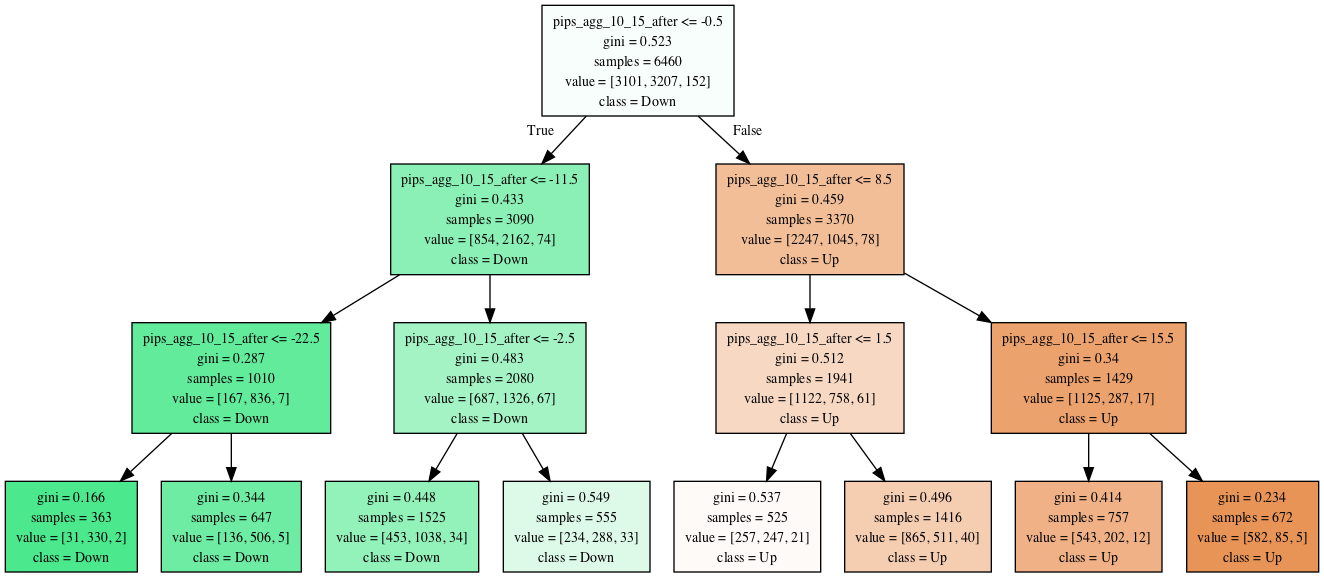

In [60]:
dot_data = tree.export_graphviz(clfd,out_file=None, filled=True, feature_names=columns_model,
                               class_names=["Up", "Down", "Accurate"])


graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [61]:
clfr = RandomForestClassifier(min_samples_leaf=50,n_estimators=200,oob_score=True)
cross_val_score(clfr,X,y,scoring="accuracy",cv=5).mean()


0.6795700888685745

In [62]:
clfr.fit(X,y)
clfr.oob_score_

0.6797213622291022

In [63]:
clfa = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),
                          n_estimators=100)
cross_val_score(clfa,X,y,scoring="accuracy",cv=5).mean()

0.5826739915996264

In [64]:
clfb = GradientBoostingClassifier(n_estimators=100)
cross_val_score(clfb,X,y,scoring="accuracy",cv=5).mean()

0.6512586526711781

In [65]:
clfxb = XGBClassifier(n_estimators=100)
cross_val_score(clfxb,X,y,scoring="accuracy",cv=5).mean()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

0.6571370544622466

In [66]:
clf_voting = VotingClassifier(estimators=[("kneigh",clf_kn),("dec",clfd), ("boost", clfb)])

In [67]:
cross_val_score(clf_voting,X,y,scoring="accuracy",cv=5).mean()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

0.666885679182941

--- 

## First regression models to predict pips variation

In [68]:
X = df_model_1[columns_model].values
y = df_model_1['pips_agg_60_90_after'].values

In [69]:
reg_kn = GridSearchCV(KNeighborsRegressor(n_neighbors=1),
                   param_grid={"n_neighbors":[40, 50, 60, 100]},
                   scoring="neg_mean_squared_error")
reg_kn.fit(X,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=1, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [40, 50, 60, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [70]:
np.sqrt(-reg_kn.best_score_)

32.40081200321208

In [71]:
reg_kn.best_params_

{'n_neighbors': 100}

In [72]:
reg_dt = GridSearchCV(DecisionTreeRegressor(min_samples_leaf=1, max_depth=1),
                   param_grid={"max_depth":range(2,5), "min_samples_leaf":[10,20,30,40,50,60,70]},
                   scoring="neg_mean_squared_error")

reg_dt.fit(X,y)
print(np.sqrt(-reg_dt.best_score_))
print(reg_dt.best_params_)

27.814720207660393
{'max_depth': 3, 'min_samples_leaf': 30}


In [74]:
reg_rf = GridSearchCV(RandomForestRegressor(min_samples_leaf=30, n_estimators=100),
                   param_grid={"min_samples_leaf":[1,2,3,5,10,15]},
                   scoring="neg_mean_squared_error")

reg_rf.fit(X,y)
print(np.sqrt(-reg_rf.best_score_))
print(reg_rf.best_params_)

27.900013299878047
{'min_samples_leaf': 15}


In [75]:
reg_xgb = GridSearchCV(XGBRegressor(n_estimators=100),
                   param_grid={},
                   scoring="neg_mean_squared_error")

reg_xgb.fit(X,y)
print(np.sqrt(-reg_xgb.best_score_))
print(reg_xgb.best_params_)


28.07067546145081
{}


In [76]:
reg_gbr = GridSearchCV(GradientBoostingRegressor(n_estimators=100),
                   param_grid={},
                   scoring="neg_mean_squared_error")

reg_gbr.fit(X,y)
print(np.sqrt(-reg_gbr.best_score_))
print(reg_gbr.best_params_)

28.22599238263806
{}
